## Predicting Halo Mass Using Machine Learning Models

### Objective and Purpose

#### I want to determine whether a Random Forest Machine Learning algorithm can predict a galaxy group's halo mass (M200) given the galaxy's (pre-calculated) $\Sigma_M$, $\Sigma_5$, Mstar, and group Ngal.
---

#### Why use ML?

##### We are using Tempel+2014 and Tempel+2017 filament and group/cluster catalogs (respectively) to characterize the environments of the WISESize sample.

##### The projected WISESize footprint, however, is a few degrees beyond the SDSS (Tempel) projection. This means there are many galaxies along the perimeter of our sample without environment flags.

##### In fact, 23% of our sample does not have a Tempel+2017 counterpart.

##### Attempts to find a linear relationship between log(M200) and any single 2D projected density parameter just produced a nontrivial amount of noise.

##### Rather than discard 23% of the galaxies, I was thus compelled to try machine learning, trained on the Tempel+2017 galaxies with halo masses, to infer halo masses for the galaxies not in Tempel+2017.
---
#### Data Credits...

##### Training M200 values are taken from Tempel+2017's group catalog, as are environment flags

##### $\Sigma_M$ and $\Sigma_5$ are both density-related parameters to characterize a galaxy's local environment and are calculated using my own algorithms found in `../wisesize/environment_classifications` (https://github.com/gammaspire/wisesize/tree/main/environment_classifications).

##### The Mstar  and[RA, DEC, Z] coordinates used here are taken from the NED-LVS catalog (Cook+21).

### Step One

---
#### The Features

##### A 'feature' refers to the galaxy properties chosen to be put into the model

##### The model then trains on these features and learns what log(M200) values or classes are most likely to be attributed to that set of features

##### Following training, the model then accepts a test set of features and tries to predict the corresponding log(M200) of the galaxies.

##### A bulk of this step involved trial and error on my end to find features which were strong indicators of halo mass. That is, I wanted features with which the model could "create" robust paths to the galaxy's log(M200). 

##### I generated a slew of $\Sigma_k$, $\Sigma_{M}$, and Ngal columns for training/testing. 

- $\Sigma_k$ = kth nearest neighbor 2D projected density 
- $\Sigma_{M}$ = 2D projected mass density
- Ngal = The number of galaxies within the same enclosed region around the galaxy used for $\Sigma_{M}$


##### I then saved the outputs to .npy files, which you can find in this directory.
---
##### I *then* row-match these features to the NED-LVS sample of galaxies which have a Tempel+2017 counterpart and are within the WISESize limits:
- 87 deg < RA < 300 deg
- -10 deg < DEC < 85 deg
- 0.002 < z < 0.025
- Do not have stellar masses lower than our mass completeness limit

##### Additionally, I imposed a halo mass limit of log(M200) > 11.5 to discard any galaxies which do not have masses physically useful for the type of science we are wanting to do.

##### This left me with around 4,000 galaxies for generating the model.

In [23]:
#load modules
import numpy as np
import pandas as pd
from rich import print
import matplotlib.pyplot as plt
from astropy.table import Table

from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from ML_M200_functions import *

import os
homedir=os.getenv('HOME')

In [8]:
#these parameters represent the bounds within which the density
#will be calculated for each central galaxy

#vr_limit in km/s, radius_limit in Mpc
#vr_limit is the "width" limit of the redshift slice that I then flatten to calculate 2D densities

vr_limits_M = [1000,1500,1500,500,600,1000,1000,1000,1000,300,300,300,1000,2000,300,1000,100,1500]
radius_limits = [1.5,1.5,1.0,1.0,1.0,0.75,0.5,1.0,2.0,2.0,1.5,0.25,0.25,2.0,1.0,3.0,0.1,3.0]
vr_limits_k = [1000,1000,1000,1000,1000]
k_list = [2,3,5,10,20]

Since I already have these features and the dataframe pre-saved, I will skip the remainder of this step. Instead, I will just load the files from this directory!

In [52]:
try:
    df = pd.read_csv('ML_features.csv')
    df_group = df.copy()[df['tempel2017_groupIDs']>0]   #isolating the Tempel+2017 group galaxies

    df_group['group_M200'] = np.log10(df_group['group_M200'])   #convert M200 to log(M200)

    df_group.replace(-999, np.nan, inplace=True)   #replace -999 with NaNs, in case there are any

    df_group = df_group.dropna()   #remove any rows with NaNs
    
    df_group = df_group[df_group['group_M200']>11.5]   #lastly, remove galaxies with halo masses < 11.5
    
except:
    print('You will have to run all of the Sigma_* variants again...have a time!')
    print('Open the "Generate..." tab above to continue.')

In [17]:
#this way, I can then avoid generating all of those features...again...for 30+ minutes.
#we will need the feature names!

SigmaM_names = np.load('SigmaMnames.npy', allow_pickle=True).tolist()
Sigmak_names = np.load('Sigmaknames.npy', allow_pickle=True).tolist()

### Step Two
---
#### Creating the Training/Testing Sample

##### The preparation of a model entails two phases: training and testing

##### That is, we train the model on a random subset of galaxies and test it on the remaining galaxies to measure its performance robustness

##### I decided to split the sample such that 80% of the galaxies were for training and 20% were for testing. This determination, again, was the product of trial and error.

##### I also used a random_state in order to ensure this random split was reproducible if I ever wanted to hold this "parameter" fixed while evaluating how other "parameters, such as the number of decision trees (N; see below), affected the model outcome.
---

In [53]:
#define all of the features!
full_feature_list = SigmaM_names + Sigmak_names

In [54]:
#the gaggle of features
X = df_group[full_feature_list]

#the 'target' quantity, log(M200)
y = df_group['group_M200']

#creating the train/test sets! I choose a random state of 63 and a test size of 0.2 (20% of sample)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=63)

### Step Three
---
#### Random Forest Model

##### A random forest model creates N decision trees based on a subset of the input features, where N is an integer.

##### With this 'forest,' the model will take an instance (e.g., a single galaxy) pass its constituent features into each tree.

##### The model then reports either an average or the model frequent outcome of the trees.

##### In particular, I used Random Forest Regression so that the model could predict log(M200) values.

##### Here, I use N=200 trees, a max depth of 15 (the maximum number of decisions a single tree can make), and a random state of 42.

In [55]:
#create the model!
model = RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42)  

In [56]:
#train the model with the testing data defined above
model.fit(X_train, y_train)

#predict the log(M200) values with this newly-trained model using the test data
y_pred = model.predict(X_test)

#### Performance Evaluation: Statistics

##### One simple approach to assessing regression model performance is to look at its R$^2$ (R) and MSE scores.

##### R is the correlation coefficient, which encodes how much of the scatter in the predicted log(M200) can be *explained* by the model. In other words, it evaluates the quality of the model with respect to how well it fits (or predicts) the data. -1 < R < 1, with 0 indicating no relationship and $\pm 1$ being a *perfect* relationship in either the positive (linear) or negative (inverse) direction.

##### MSE is the **Mean Squared Error**, or the average of the squared differences between the actual and predicted log(M200) values. A lower value, thus, means a better performance overall of the model:

$MSE=\frac{1}{n}\sum _{i=1}^{n}(y_{true, i}-{y}_{pred, i})^{2}$

##### If MSE = 0.5, for instance, that would mean that, on average, the difference between the predicted and "true" log(M200) values is about 0.71 dex.

In [57]:
#performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f} (R: {np.sqrt(r2):.3f})")

MSE: 0.240

R²: 0.656 (R: 0.810)

#### Performance Evaluation: Plots

##### A second integral diagnostic tool of model performance is through visual representations of the data - namely, plots.

##### With code that I have written and included in this repository, I can automate all of the steps above and output two figures...
---
#### FIGURE ONE
- A plot of the model-predicted (y_pred) vs. the "true" (y_true) log(M200) values, color-coded by the number of galaxies in each group or cluster. 
- I use the colors to determine whether the model is particularly poor at predicting log(M200) for a certain Ngal range, which I find to be 2-3 and even 4-6 -- the dwarfy groups.
- The Black dashed line is a 1-to-1 reference, meaning that points on this line have the same y_pred and y_true.
- There is also a slightly jittery Black solid line and a companion shaded region, which in conjunction show the median and spread of y_true in some slice of y_pred. That is...
    - For every y_pred, I create a "bucket" centered on that value with a width of $\pm 0.3$ dex. Every y_pred within this width is tossed into the bucket. Since every y_pred has a y_true value, those y_true values also habitate the bucket.
    - I take every y_true value in this bucket and calculate the median, which contributes one point to the Black solid line
    - I then calculate the 68% confidence intervals of these y_true values, which contribute a small segment of the shaded region
##### Why?
- If the model is predicting some log(M200) for a large array of "true" log(M200), then the model is not doing well.
- That is, we cannot trust galaxies that are assigned that predicted log(M200), since it very likely does not represent the "true" log(M200) value.
- While I attempted to automate the detection of this threshold log(M200), as indicated by the output text mentioning a threshold, the most reliable approach is 'by eye.'
- This involves finding where the CI widths become noticeably tighter about the median curve (solid black).
##### Verdict:
- With 68 features, the model does reasonably well at predicting halo masses, a variable notorious for its scatter due to a myriad of astronomical factors. Even though the confidence intervals fan out at low "true" log(M200), the uncertainty I would report is *only* on the order of $\pm$0.5 dex. 
- The model performs best in the intermediate regime of the pred-true space, with an uncertainty of around $\pm$0.1 or 0.2 dex.
- At the high end, there is more jaggedness to the median line. This could be due to this artificial "vertical striping" effect, caused by galaxies in the same group/cluster having the same "true" halo mass but obviously different predicted halo masses. This effect is, of course, most noticeable for galaxies with the largest log(M200) simply because they contain 20+ galaxies in their group/cluster halo.
---
#### FIGURE TWO
- A histogram plot of all of the features and the relative importance that the model 'assigned' when predicting halo mass. The features with the highest importances, therefore, are those that the model relies on the most as the most robust indicators of halo mass. 
- As there are 67 features, the plot is evidently cluttered and untidy. What we can glean from this, however, is that most features contribute only negligibly to the model generation.
- This figure is the impetus for feature trimming, which will be the next step.

No force_features_list found in the parameters .txt file!

Searching for SigmaM and Sigmak .npy files...

Success!

MSE: 0.240

R²: 0.656 (R: 0.810)

Model becomes 'reliable' above predicted log(M200) ≈ 13.62 for a threshold of 0.7

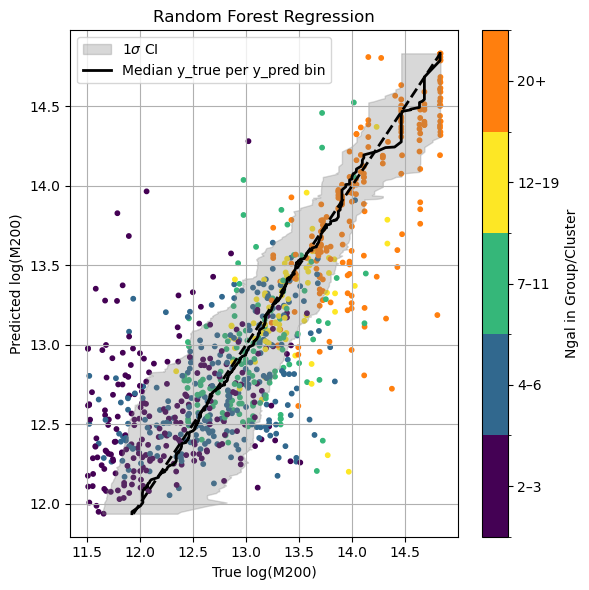

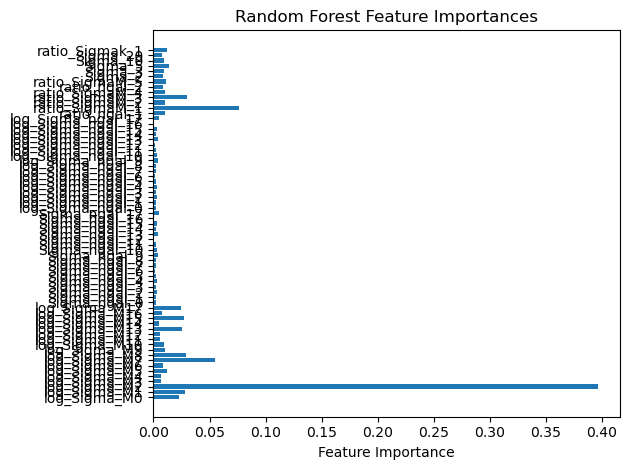

In [66]:
#version with Random Forest
%run ML_M200_regression.py

##### Before continuing, here are rough steps for running the automation code:

##### Be sure to edit the relevant parameters.txt file beforehand
###### (For Random Forest Regression, rf_regression_parameters.txt)
##### To print "help" text, use -h or --help
###### e.g., %run ML_M200_regression.py -h
###### python ML_M200_regression.py -h
##### User has option to input a df or list of feature names; otherwise, run Steps 1a and 1b above to generate features and the df row-matched to the galaxy parent sample.

### Step Four
---
##### Primarily for elegance and simplicity considerations, which are more vanity than epistemic virtues, I decided to prune some of my features.

##### Largely due to the trial and error I noted in the introduction, there are 67 total features. Some also involve a little engineering, namely calculating ratios between either $\Sigma_M$ values or Ngal values to probe gradients in a galaxy's local density space. 

##### To help visualize how both the medians and confidence intervals discussed above are affected by the number of "most important" features that are fed into a model, I wrote plot_regression_CI.py which draws on functions the other two .py files to loop over an input list (in the script itself) of the number of most important features I want the model to iterate over.

Using 67 "important" feature(s)...

The length of X_features is smaller than or the same as N_output. Defaulting to X_features column names.

MSE: 0.240

R²: 0.656 (R: 0.810)

Using 33 "important" feature(s)...

Index(['log_Sigma_ngal_17', 'Sigma_ngal_17', 'log_Sigma_M14', 'log_Sigma_M11',
       'log_Sigma_M12', 'log_Sigma_M4', 'log_Sigma_M3', 'Sigma_20',
       'log_Sigma_M16', 'log_Sigma_M6', 'Sigma_2', 'ratio_ngal_2',
       'log_Sigma_M10', 'Sigma_3', 'Sigma_10', 'ratio_ngal_1',
       'ratio_SigmaM_4', 'ratio_SigmaM_2', 'log_Sigma_M9', 'ratio_SigmaM_5',
       'ratio_Sigmak_1', 'log_Sigma_M5', 'Sigma_5', 'log_Sigma_M0',
       'log_Sigma_M17', 'log_Sigma_M13', 'log_Sigma_M15', 'log_Sigma_M1',
       'log_Sigma_M8', 'ratio_SigmaM_3', 'log_Sigma_M7', 'ratio_SigmaM_1',
       'log_Sigma_M2'],
      dtype='object')

MSE: 0.245

R²: 0.650 (R: 0.806)

Using 6 "important" feature(s)...

Index(['log_Sigma_M1', 'ratio_SigmaM_3', 'log_Sigma_M8', 'log_Sigma_M7',
       'ratio_SigmaM_1', 'log_Sigma_M2'],
      dtype='object')

MSE: 0.286

R²: 0.592 (R: 0.769)

Using 5 "important" feature(s)...

Index(['log_Sigma_M7', 'log_Sigma_M1', 'log_Sigma_M8', 'ratio_SigmaM_1',
       'log_Sigma_M2'],
      dtype='object')

MSE: 0.285

R²: 0.593 (R: 0.770)

Using 3 "important" feature(s)...

Index(['ratio_SigmaM_1', 'log_Sigma_M8', 'log_Sigma_M2'], dtype='object')

MSE: 0.306

R²: 0.563 (R: 0.750)

Using 1 "important" feature(s)...

Index(['log_Sigma_M2'], dtype='object')

MSE: 0.347

R²: 0.504 (R: 0.710)

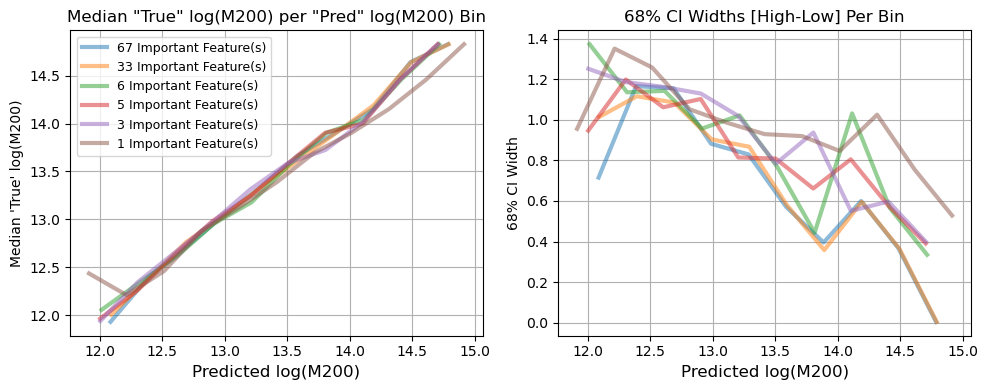

In [73]:
%run plot_regression_CI.py

##### The figure above shows the resulting performances of each model trained on N number of features, defined by the legend key to the upper left of the left plot. Both x-axis give the center y_pred  of each y_pred bin. 

##### The left plot, which gives the median y_true for the y-axis, indicates that robust log(M200) values can be obtained by training the model on just 3-6 of the most dominant features. That is, these features almost superimpose the model wherein I use the full 67 features, which confirms the interpretation of the importances plot -- many of these features negligibly impact the model and may be comfortably discarded.

##### The right plot, meanwhile, plots the 68% confidence interval (CI) width for the model, corresponding to the width of the shaded region in the previous section. Model predictions appear reasonable at the lowest halo masses, even appearing to plateau to a degree at a width of 1.0-1.2 dex.

##### For the case of 5 features, the model outputs

    * R²: 0.593 (R: 0.770)
    * MSE: 0.285

##### While slightly lower than the case of 67 features, these statistics further illustrate the robustness of the model for 5 and even 6 features. 

##### Let's now run the model with the 6 most optimal features. 
##### *Note that I replace log_SigmaM_3 with log_Sigma_M17 due to the latter reducing scatter even further:*

    * log_Sigma_M1   -- radius limit 1.5 Mpc, velocity limit 1500 km/s
    * log_Sigma_M2   -- radius limit 1.0 Mpc, velocity limit 1500 km/s
    * log_Sigma_M7   -- radius limit 1.0 Mpc, velocity limit 1000 km/s
    * log_Sigma_M8   -- radius limit 2.0 Mpc, velocity limit 1000 km/s
    * log_Sigma_M17  -- radius limit 3.0 Mpc, velocity limit 1500 km/s
    * ratio_SigmaM_1 -- radius limit 1.0 Mpc, velocity limit 1000 km/s vs. 300 km/s

MSE: 0.274

R²: 0.608 (R: 0.780)

Model becomes 'reliable' above predicted log(M200) ≈ 13.59 for a threshold of 0.7

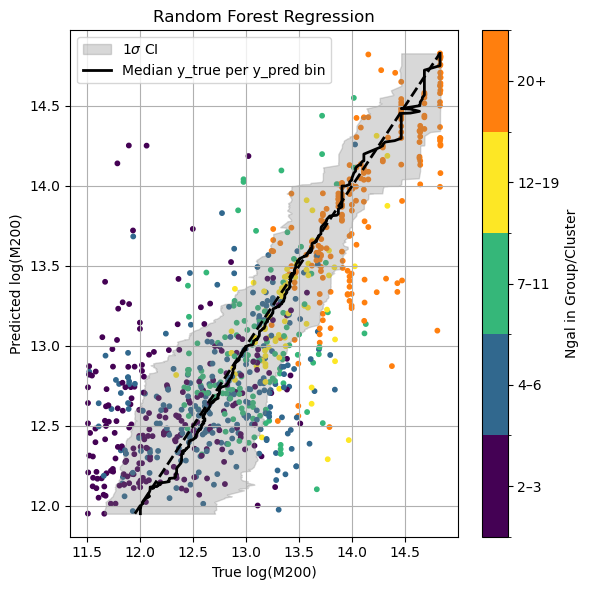

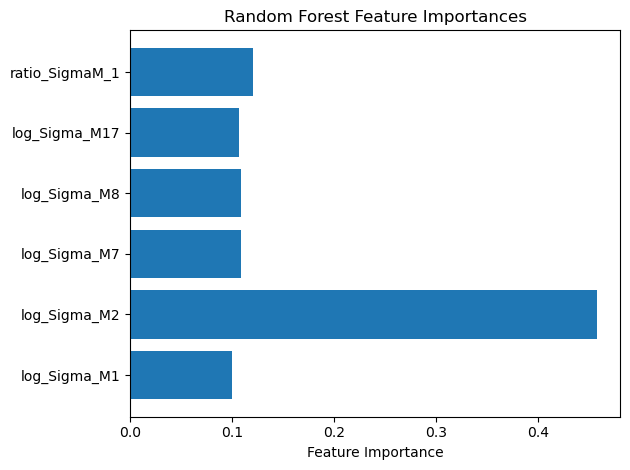

In [76]:
#version with Random Forest
%run ML_M200_regression.py

### A fun little conclusion...

#### The use of a Random Forest regression model, thus, allows me to estimate halo mass for nearly 25% of the WISEsize sample which is not included in the Tempel+2017 catalog.

## Miscellaneous: Random Forest Classification with Halo Mass

### While my advisors and I agreed that using continuous halo mass values was preferrable to creating classes (or "buckets," to make reference to the discussion on confidence intervals) of halo mass, I keep the relic of my exploration here for purposes of completion.

##### (and in case I decide to ever return to these notes to refresh my memory on how to use Classifier models)

##### Random Forest M200 Classification (Tempel+2017 groups and M200)
###### 0 = [12.5<M200], 1 = [12.5<M200<14.],  2 = [M200>14.]
###### Best result (ALL 67 FEATURES): 78.70% accuracy 

In [106]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

In [87]:
df_group = df.copy()[df['tempel2017_groupIDs']>0]

#convert M200 to log(M200)
df_group['group_M200'] = np.log10(df_group['group_M200'])

#replace -999 with NaNs, in case there are any lingering buggers
df_group.replace(-999, np.nan, inplace=True)

#REMOVE NaNs
df_group = df_group.dropna()

In [88]:
#we will NOT be removing logM200<11.5 galaxies!

In [104]:
#M200 bins
bin1 = df_group['group_M200'] < 12.5   #loosely corresponding to field
bin2 = (df_group['group_M200'] >= 12.5) & (df_group['group_M200'] < 14.)   #loosely corresponding to groups
bin3 = (df_group['group_M200'] >= 14.)   #loosely corresponding to clusters

df_group.loc[:, 'env_class'] = np.select([bin1, bin2, bin3], [0, 1, 2])

In [105]:
#check whether number of galaxies in each "bin" is relatively balanced
#if not...just make sure the model class_weight is set to 'balanced'
print(df_group['env_class'].value_counts())

env_class
1    2513
0    2214
2     648
Name: count, dtype: int64

In [92]:
#define general X, y sets
X = df_group[full_feature_list]
y = df_group['env_class']

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [107]:
#define your model of choice
model = RandomForestClassifier(
    n_estimators=80,
    max_depth=14,
    class_weight='balanced',
    random_state=42,
    max_features='sqrt')

In [94]:
#train ze model
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=14, n_estimators=80,
                       random_state=42)

In [95]:
y_pred = model.predict(X_test)

In [96]:
accuracy = (np.sum(np.diag(confusion_matrix(y_test, y_pred)))) / (np.sum(confusion_matrix(y_test, y_pred))) 
print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 78.70%

NOTE: F1 is a sort of 'harmonic mean' of precision ("out of all positive predictions, how many were corect?") and recall ("out of all active positives, how many did the model catch?"). High F1 --> high precision and high recall. 

A 'harmonic mean' punishes extreme imbalances.

A high f1_macro corresponds to the model performing with robust precision AND recall for every class.

In [97]:
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, digits=3))

precision    recall  f1-score   support

           0      0.771     0.806     0.788       443
           1      0.798     0.740     0.768       503
           2      0.801     0.907     0.851       129

    accuracy                          0.787      1075
   macro avg      0.790     0.817     0.802      1075
weighted avg      0.787     0.787     0.786      1075

<Axes: >

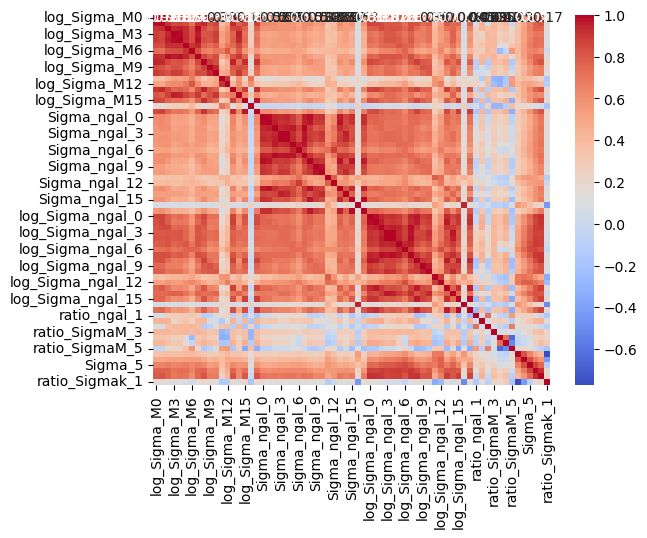

In [103]:
#CORRELATION MAP! Check if there are any redundant features (correlation > 0.95 or so)

import seaborn as sns
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')

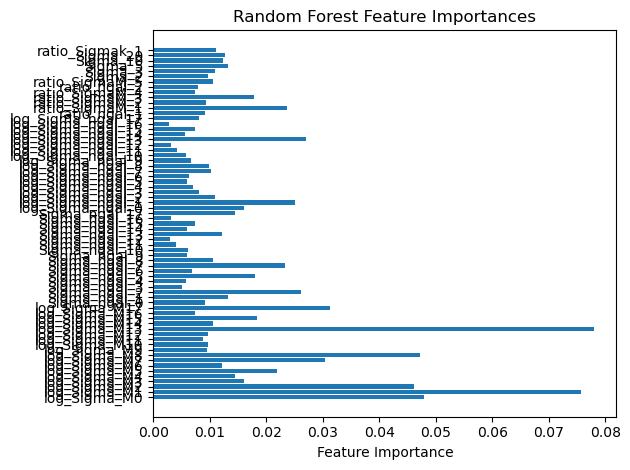

In [98]:
importances = model.feature_importances_
features = X.columns

plt.barh(features, importances)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()

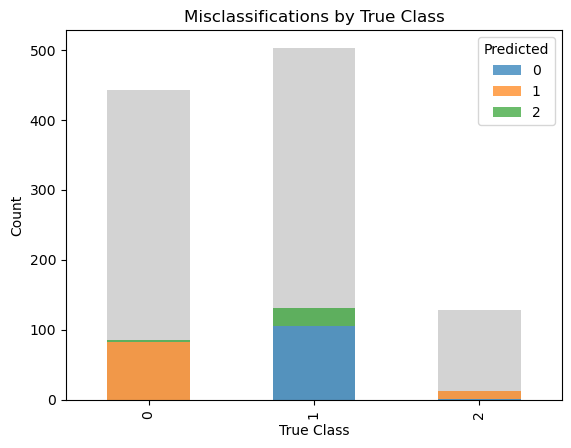

In [115]:
'''
Input: the true y-values, the predicted y-values from the ML model
Output: histogram plot of True Classes, the total number of true galaxies 
        per class (gray background), and the number of galaxies in the True 
        Class which were misclassified as the other two classes (color-coded 
        according to the legend). 

        FOR EXAMPLE, if Class 0 had 77 misclassified galaxies, the plot will 
        show how many of those were misclassified as what classes...and since 
        the gray shows the total number of galaxies in the True Class, the difference 
        between the total height of the "misclassifications" and the "total" yields 
        the number of galaxies correctly classified.
'''

#extract the total number of test galaxies in each class
cm = confusion_matrix(y_test, y_pred)
true_class_totals = cm.sum(axis=1)

#find where the predicted class is not the same as the true class
errors = (y_test != y_pred)

#creating a new dataframe with true classes, predicted classes, and an error flag
error_df = pd.DataFrame({'True': y_test, 'Predicted': y_pred, 'Error': errors})

#sums the number of "True" errors
error_counts = error_df[error_df['Error']].groupby(['True', 'Predicted']).size().unstack(fill_value=0)

#plot the results...stacked means that the colors are, quite literally, stacked like LEGO bricks.
error_counts.plot(kind='bar', stacked=True, alpha=0.7)

plt.bar(error_counts.index, true_class_totals, color='lightgray', label='Total true count', zorder=0, width=0.5)

plt.title("Misclassifications by True Class")
plt.ylabel("Count")
plt.xlabel("True Class")
plt.show()